# **2024 Coding Challenge: Automated Object Detection and Counting**
**Author:** Taïsha V. Joseph

**Objective:** Develop a Python-based application that uses computer vision techniques to count and classify different objects from a set of images. The system should be able to differentiate at least three types of objects (e.g., cars, bicycles, pedestrians) in diverse lighting and background conditions.

**Resources:**
- http://cocodataset.org/
- https://github.com/cocodataset/cocoapi/tree/master
- https://github.com/ultralytics/yolov5
- https://docs.ultralytics.com/yolov5/tutorials/train_custom_data/#clearml-logging-and-automation-new
- https://github.com/ultralytics/yolov5/blob/master/tutorial.ipynb

In [36]:
# !rm -r /content/data/filtered

## Helper Functions

In [4]:
# Helper functions
def generate_direct_download_link(shared_link):
    """
    Generates a direct download link from a shared Google Drive link.

    Args:
        shared_link (str): The shared Google Drive link.

    Returns:
        str: The direct download link or an error message.

    Raises:
        ValueError: If the provided link is not a valid Google Drive shared link.
    """
    try:
        # Check if the shared link is a valid Google Drive link
        if "drive.google.com/file/d/" not in shared_link:
            raise ValueError("The provided link is not a valid Google Drive shared link.")

        # Extract the file ID from the shared link
        file_id = shared_link.split('/d/')[1].split('/')[0]

        # Create the direct download link
        direct_download_link = f"https://drive.google.com/uc?export=download&id={file_id}"
        print (direct_download_link)

        return direct_download_link
    except Exception as e:
        return f"An error occurred: {e}"


In [5]:
import os
import subprocess
import torch

def download_from_gdrive(gdrive_url, output_path):
    """
    Downloads a file from Google Drive.

    Parameters:
    gdrive_url (str): Google Drive direct download URL.
    output_path (str): Path where the downloaded file will be saved.

    Returns:
    bool: True if the download was successful, False otherwise.
    """
    try:
        subprocess.check_call(['gdown', gdrive_url, '-O', output_path])
        print(f"Downloaded {gdrive_url} to {output_path}")
        return True
    except subprocess.CalledProcessError as e:
        print(f"Google Drive download failed for {gdrive_url}. Error: {e}")
        return False

def download_from_url(url, output_path):
    """
    Downloads a file from a given URL.

    Parameters:
    url (str): URL of the file to be downloaded.
    output_path (str): Path where the downloaded file will be saved.

    Returns:
    bool: True if the download was successful, False otherwise.
    """
    try:
        torch.hub.download_url_to_file(url, output_path)
        print(f"Downloaded {url} to {output_path}")
        return True
    except Exception as e:
        print(f"Download failed for {url}. Error: {e}")
        return False

In [6]:
import zipfile
import os

def extract_zip_files(zip_files, extract_to):
    """
    Extracts a list of zip files to a specified directory.

    Args:
        zip_files (list): List of paths to the zip files.
        extract_to (str): Directory where the zip files will be extracted.
    """
    for local_zip in zip_files:
        try:
            # Check if the zip file exists
            if not os.path.isfile(local_zip):
                print(f"Error: File {local_zip} does not exist.")
                continue

            # Open the zip file
            with zipfile.ZipFile(local_zip, 'r') as zip_ref:
                # Extract all the contents of the zip file
                zip_ref.extractall(extract_to)
                print(f"Extracted {local_zip} to {extract_to}")

        except zipfile.BadZipFile:
            print(f"Error: {local_zip} is not a valid zip file.")
        except Exception as e:
            print(f"An unexpected error occurred while extracting {local_zip}: {e}")


In [7]:
from pycocotools.coco import COCO
import os
import shutil
import json
import random

def ensure_dir_exists(directory):
    """
    Ensure that a directory exists. If it does not, create it.

    Parameters:
    directory (str): The directory path to check/create.
    """
    if not os.path.exists(directory):
        os.makedirs(directory)

def filter_coco_annotations(input_annotation_file, output_annotation_file, image_dir, output_image_dir, categories_to_keep, full=False):
    """
    Filter COCO annotations to only include specified categories and copy corresponding images.

    Parameters:
    input_annotation_file (str): Path to the input COCO annotations file.
    output_annotation_file (str): Path to the output filtered annotations file.
    image_dir (str): Directory containing the input images.
    output_image_dir (str): Directory to store the filtered images.
    categories_to_keep (list): List of category names to keep.

    Raises:
    Exception: For unforeseen errors.
    """
    import json
    import os
    import shutil
    from pycocotools.coco import COCO
    import random

    try:
        # Load COCO dataset
        coco = COCO(input_annotation_file)
        category_ids = coco.getCatIds(catNms=categories_to_keep)
        print("Category IDs:", category_ids)
        print("Categories to keep:", categories_to_keep)

        image_ids_per_category = {cat_id: coco.getImgIds(catIds=[cat_id]) for cat_id in category_ids}

        if full == True:
          for cat_id, img_ids in image_ids_per_category.items():
            print(f"Number of images for category {cat_id}: {len(img_ids)}")
        else:
          n = 500
          for cat_id, img_ids in image_ids_per_category.items():
            if len(img_ids) > n:
              image_ids_per_category[cat_id] = random.sample(img_ids, n)
            else:
              image_ids_per_category[cat_id] = img_ids
          # image_ids_per_category = {cat_id: random.sample(img_ids, n) for cat_id, img_ids in image_ids_per_category.items() if len(img_ids) > n}
          for cat_id, img_ids in image_ids_per_category.items():
            print(f"Number of images for category {cat_id}: {len(img_ids)}")

        # Collect all images for specified categories
        final_image_ids = [img_id for ids in image_ids_per_category.values() for img_id in ids]
        print("Final image IDs:", final_image_ids)

        filtered_annotations = []
        filtered_images = []

        # Ensure output directories exist
        ensure_dir_exists(output_image_dir)
        ensure_dir_exists(os.path.dirname(output_annotation_file))

        # Process each image
        for img_id in final_image_ids:
            img_info = coco.loadImgs(img_id)[0]
            ann_ids = coco.getAnnIds(imgIds=img_id, catIds=category_ids)
            anns = coco.loadAnns(ann_ids)
            # print(f"Image ID {img_id} annotations:", anns)

            filtered_images.append(img_info)
            filtered_annotations.extend(anns)

            # Copy image to output directory
            src_img_path = os.path.join(image_dir, img_info['file_name'])
            dst_img_path = os.path.join(output_image_dir, img_info['file_name'])
            shutil.copy(src_img_path, dst_img_path)

        # Create filtered data dictionary
        filtered_data = {
            'images': filtered_images,
            'annotations': filtered_annotations,
            'categories': [cat for cat in coco.loadCats(category_ids)]
        }

        # Write filtered data to JSON file
        with open(output_annotation_file, 'w') as f:
            json.dump(filtered_data, f)

        print("Filtering and copying completed successfully.")

    except Exception as e:
        print(f"An error occurred: {e}")


In [8]:
def convert_coco_to_yolo(annotations_file, labels_dir):
    """
    Converts COCO annotations to YOLO format and saves them in the specified directory.

    Parameters:
    annotations_file (str): Path to the COCO annotations JSON file.
    labels_dir (str): Directory where YOLO labels will be saved.

    Raises:
    FileNotFoundError: If the annotations file is not found.
    KeyError: If expected keys are missing in the annotations file.
    Exception: For other unforeseen errors.
    """
    import json
    import os

    try:
        # Load the COCO annotations file
        with open(annotations_file, 'r') as f:
            data = json.load(f)

        # Create a dictionary to map category IDs to category names
        categories = {cat['id']: cat['name'] for cat in data['categories']}
        print("Categories (ID to Name):", categories)

        # Create a dictionary to map category names to YOLO class indices
        category_to_index = {name: index for index, name in enumerate(categories.values())}
        print("Category to Index:", category_to_index)

        # Ensure the labels directory exists
        os.makedirs(labels_dir, exist_ok=True)

        # Iterate over all annotations in the COCO dataset
        for ann in data['annotations']:
            try:
                image_id = ann['image_id']
                category_id = ann['category_id']
                bbox = ann['bbox']
                category_name = categories[category_id]
                # print("Annotation:", ann)
                # print("Category Name:", category_name)

                # Skip categories that are not in the category_to_index dictionary
                if category_name not in category_to_index:
                    continue

                # Get image information to calculate normalized bounding box coordinates
                image_info = next(img for img in data['images'] if img['id'] == image_id)
                image_width = image_info['width']
                image_height = image_info['height']

                # Calculate YOLO format coordinates (normalized)
                x_center = (bbox[0] + bbox[2] / 2) / image_width
                y_center = (bbox[1] + bbox[3] / 2) / image_height
                width = bbox[2] / image_width
                height = bbox[3] / image_height

                # Create the YOLO label string
                yolo_label = f"{category_to_index[category_name]} {x_center} {y_center} {width} {height}\n"

                # Determine the label file path based on the image file name (without extension)
                label_file_path = os.path.join(labels_dir, f"{image_info['file_name'].split('.')[0]}.txt")

                # Append the YOLO label to the label file
                with open(label_file_path, 'a') as label_file:
                    label_file.write(yolo_label)

            except KeyError as e:
                print(f"KeyError encountered: {e}")
                continue
            except StopIteration:
                print(f"Image with ID {image_id} not found in the images list.")
                continue
            except Exception as e:
                print(f"Unexpected error encountered: {e}")
                continue

    except FileNotFoundError as e:
        print(f"FileNotFoundError: {e}")
    except KeyError as e:
        print(f"KeyError in annotations file: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")

In [3]:
import shutil
from google.colab import files

def zip_and_download_folder(folder_to_zip, output_filename):
    """
    Zips a specified folder and downloads the zipped file.

    Args:
        folder_to_zip (str): Path to the folder to be zipped.
        output_filename (str): Path where the zipped file will be saved.
    """
    try:
        # Step 1: Zip the folder
        # Check if the folder exists
        if not os.path.isdir(folder_to_zip):
            print(f"Error: Folder {folder_to_zip} does not exist.")
            return

        # Create the zip file
        shutil.make_archive(output_filename.replace('.zip', ''), 'zip', folder_to_zip)
        print(f"Folder {folder_to_zip} zipped successfully as {output_filename}")

    except Exception as e:
        print(f"An error occurred while zipping the folder: {e}")
        return

    try:
        # Step 2: Download the zipped folder
        # Check if the zip file was created successfully
        if not os.path.isfile(output_filename):
            print(f"Error: File {output_filename} was not created.")
            return

        files.download(output_filename)
        print(f"File {output_filename} downloaded successfully")

    except Exception as e:
        print(f"An error occurred while downloading the file: {e}")

## Download Data

- Get COCO training and validation datasets
- Locally, the zip files can be downloaded and extracted using the Python script *download_data.py*
- In the Google Colab notebook, for faster download, the zip files were stored in my Google Drive and anyone with the links can download the datasets to Google Colab using *gdrive*.
- The code for downloading the datasets from Google Drive or directly from the COCO website can be found in the cells below.

In [43]:
!rm -r /content/sample_data

rm: cannot remove '/content/sample_data': No such file or directory


In [44]:
# Do not change this code
!pip install --upgrade --no-cache-dir gdown

Organize local directory before getting datasets

In [45]:
!mkdir /content/data/
!mkdir /content/data/filtered/
!mkdir /content/data/tmp/

mkdir: cannot create directory ‘/content/data/’: File exists
mkdir: cannot create directory ‘/content/data/filtered/’: File exists
mkdir: cannot create directory ‘/content/data/tmp/’: File exists


In [46]:
# Google Drive shared link for the necessary files
val2017 = "https://drive.google.com/file/d/18rji_6JgJYIBfv7EY2PQP3nQA689ZR2I/view?usp=sharing"
train2017 = "https://drive.google.com/file/d/1RgUrTkclcqtT8FVl912XCzX3jIahQwBU/view?usp=sharing"
annotations_trainval2017 = "https://drive.google.com/file/d/10oTb3FBJbWz7ZKjw2G-udamNMCBfYtuF/view?usp=sharing"

In [47]:
# transform shared google drive shared links into direct download links
train2017 = generate_direct_download_link(train2017)
val2017 = generate_direct_download_link(val2017)
annotations_trainval2017 = generate_direct_download_link(annotations_trainval2017)

https://drive.google.com/uc?export=download&id=1RgUrTkclcqtT8FVl912XCzX3jIahQwBU
https://drive.google.com/uc?export=download&id=18rji_6JgJYIBfv7EY2PQP3nQA689ZR2I
https://drive.google.com/uc?export=download&id=10oTb3FBJbWz7ZKjw2G-udamNMCBfYtuF


**Optional:** Download COCO datasets directly from the COCO website (takes longer than exporting from Google Drive)

In [48]:
output_dir = '/content/data/tmp/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

train_zip_path = os.path.join(output_dir, 'train2017.zip')
val_zip_path = os.path.join(output_dir, 'val2017.zip')
annotations_zip_path = os.path.join(output_dir, 'annotations_trainval2017.zip')

# Download train dataset
if not download_from_gdrive(train2017, train_zip_path):
  train2017 = "http://images.cocodataset.org/zips/train2017.zip"
  download_from_url(train2017, train_zip_path)

# Download validation dataset
if not download_from_gdrive(val2017, val_zip_path):
  val2017 = "http://images.cocodataset.org/zips/val2017.zip"
  download_from_url(val2017, val_zip_path)

# Download annotations
if not download_from_gdrive(annotations_trainval2017, annotations_zip_path):
  annotations_trainval2017 = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
  download_from_url(annotations_trainval2017, annotations_zip_path)

Downloaded https://drive.google.com/uc?export=download&id=1RgUrTkclcqtT8FVl912XCzX3jIahQwBU to /content/data/tmp/train2017.zip
Downloaded https://drive.google.com/uc?export=download&id=18rji_6JgJYIBfv7EY2PQP3nQA689ZR2I to /content/data/tmp/val2017.zip
Downloaded https://drive.google.com/uc?export=download&id=10oTb3FBJbWz7ZKjw2G-udamNMCBfYtuF to /content/data/tmp/annotations_trainval2017.zip


In [49]:
# List of zip files to extract
zip_files = [
    '/content/data/tmp/train2017.zip',
    '/content/data/tmp/val2017.zip',
    '/content/data/tmp/annotations_trainval2017.zip'
]

# Directory to extract the zip files to
extract_to = '/content/data/tmp'

# Extract the zip files
extract_zip_files(zip_files, extract_to)

Extracted /content/data/tmp/train2017.zip to /content/data/tmp
Extracted /content/data/tmp/val2017.zip to /content/data/tmp
Extracted /content/data/tmp/annotations_trainval2017.zip to /content/data/tmp


## 2.Data Prep

2.1. Filter COCO Annotations
- Filter the annotations for the classes person, car, and bicycle.
- In this section, I will update the annotations and copy the relevant images to a new directory.
- *Load the COCO annotations using pycocotools (input_annotation_file).*

    - Get category IDs for the classes of interest using getCatIds(catNms=categories_to_keep).
    - Get image IDs associated with the filtered categories using getImgIds(catIds=category_ids).

- *Filtering Process:*

    - Iterate over the filtered image IDs.
    - Load image information and corresponding annotations.
    - Append filtered images and annotations to the respective lists.
    - Copy relevant images to the output directory.
    
- *Saving Filtered Data:*

    - Save the filtered images, annotations, and categories to the output annotation file in COCO format.

**Counting and Sampling:** The code counts the number of images per class and samples an equal number of images from each class to balance the dataset.
**Incorporating Non-specific Images:** It randomly selects a specified number of images that do not contain any of the target classes and adds them to the final dataset.

In [ ]:
# !pip install pycocotools

In [62]:
# !rm -r /content/data/filtered/

In [63]:
categories_to_keep = ['person', 'car', 'bicycle']

In [64]:
filter_coco_annotations(
    '/content/data/tmp/annotations/instances_train2017.json',
    '/content/data/filtered/annotations/filtered_instances_train2017.json',
    '/content/data/tmp/train2017',
    '/content/data/filtered/images/train2017',
    categories_to_keep
)

loading annotations into memory...
Done (t=14.14s)
creating index...
index created!
Category IDs: [1, 2, 3]
Categories to keep: ['person', 'car', 'bicycle']
Number of images for category 1: 500
Number of images for category 2: 500
Number of images for category 3: 500
Final image IDs: [258628, 418811, 208079, 149938, 347989, 122118, 116712, 400829, 153052, 554953, 269829, 554381, 25812, 424683, 454745, 444467, 91336, 11227, 258132, 240033, 147941, 176519, 416477, 94877, 536562, 258094, 491282, 179850, 498508, 158137, 171915, 150686, 480599, 99629, 114424, 540404, 125118, 167973, 347640, 345883, 291898, 410779, 211690, 217546, 281105, 42860, 517382, 501926, 571920, 505234, 1536, 397526, 428403, 45136, 9451, 239532, 255479, 10249, 216524, 48384, 236272, 435937, 157426, 238827, 534391, 17877, 294847, 581091, 117178, 89288, 349689, 519832, 217855, 412697, 58873, 326947, 15564, 472103, 430335, 506290, 77063, 148042, 486045, 222370, 109513, 416258, 310882, 193384, 425822, 572233, 78633, 18555

In [65]:
filter_coco_annotations(
    '/content/data/tmp/annotations/instances_val2017.json',
    '/content/data/filtered/annotations/filtered_instances_val2017.json',
    '/content/data/tmp/val2017',
    '/content/data/filtered/images/val2017',
    categories_to_keep
)

loading annotations into memory...
Done (t=0.38s)
creating index...
index created!
Category IDs: [1, 2, 3]
Categories to keep: ['person', 'car', 'bicycle']
Number of images for category 1: 500
Number of images for category 2: 149
Number of images for category 3: 500
Final image IDs: [357737, 485027, 417779, 413404, 78565, 407646, 423617, 167572, 567886, 455597, 19924, 23899, 513524, 263969, 179487, 273760, 154644, 537991, 274411, 290179, 259571, 372577, 124442, 145620, 179898, 100510, 14473, 188465, 161781, 246968, 79229, 220732, 137106, 312489, 227491, 202228, 80659, 439593, 36936, 563267, 785, 440184, 578792, 150649, 565563, 297022, 261318, 270122, 530061, 474078, 334399, 516318, 334417, 39951, 395388, 142238, 319721, 209753, 245320, 437351, 555597, 98392, 55002, 17899, 157046, 505638, 397354, 118921, 142585, 407868, 9378, 159399, 93261, 128476, 352491, 223182, 458255, 481480, 495732, 47819, 163057, 368294, 107339, 82821, 579307, 231747, 213086, 306136, 84170, 37689, 191845, 563470, 

In [ ]:
# !rm -r /content/data/tmp

2.2 Convert COCO Annotations to YOLO Format
Convert the filtered COCO annotations to YOLO format (i.e., .txt files as labels for each image).

In [66]:
convert_coco_to_yolo(
    '/content/data/filtered/annotations/filtered_instances_train2017.json',
    '/content/data/filtered/labels/train2017'#,categories_to_keep
)

Categories (ID to Name): {1: 'person', 2: 'bicycle', 3: 'car'}
Category to Index: {'person': 0, 'bicycle': 1, 'car': 2}


In [67]:
convert_coco_to_yolo(
    '/content/data/filtered/annotations/filtered_instances_val2017.json',
    '/content/data/filtered/labels/val2017'#,categories_to_keep
)

Categories (ID to Name): {1: 'person', 2: 'bicycle', 3: 'car'}
Category to Index: {'person': 0, 'bicycle': 1, 'car': 2}


## **Train**
**2 Options for training a model with YOLOv5:**

- Fine-tune a pre-trained model with pre-exisiting weights
- **Train a model from scratch**


## **yolov5n architecture:**
### Loss functions:
Classification loss:
  1. Binary Cross-Entropy with Logits Loss (BCEWithLogitsLoss)
  2. FocalLoss (variant of cross-entropy that handles class imbalance) if gamma (focusing param) > 0
Bounding Box regression loss:
  1. Complete Intersection over Union (IoU) loss

### Activation function
- SiLU (Swish) Activation Function (default)

### Hyperparams:

```yaml
# Ultralytics YOLOv5 🚀, AGPL-3.0 license (customized)

# Parameters
nc: 3 # number of classes (modified)
depth_multiple: 0.5 # model depth multiple (modified)
width_multiple: 0.5 # layer channel multiple (modified)
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, nn.Dropout, [0.2]],  # Adding Dropout with 20% probability
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13
    [-1, 1, nn.Dropout, [0.2]],  # Adding Dropout with 20% probability

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 4], 1, Concat, [1]], # cat backbone P3
    [-1, 3, C3, [256, False]], # 17 (P3/8-small)
    [-1, 1, nn.Dropout, [0.2]],  # Adding Dropout with 20% probability

    [-1, 1, Conv, [256, 3, 2]],
    [[-1, 14], 1, Concat, [1]], # cat head P4
    [-1, 3, C3, [512, False]], # 20 (P4/16-medium)
    [-1, 1, nn.Dropout, [0.3]],  # Adding Dropout with 30% probability

    [-1, 1, Conv, [512, 3, 2]],
    [[-1, 10], 1, Concat, [1]], # cat head P5
    [-1, 3, C3, [1024, False]], # 23 (P5/32-large)
    [-1, 1, nn.Dropout, [0.5]],  # Adding Dropout with 50% probability

    [[17, 20, 23], 1, Detect, [nc, anchors]], # Detect(P3, P4, P5)
  ]
```

### Train Model (smallest one is yolov5n) from scratch
Should be in *~/Documents/Projects/yolov5/* directory

- Navigate to the models folder in the cloned yolov5 repo
- Modify the "yolov5n.yaml" file by replacing the number of classes from 80 to 3
- Adjust other parameters for each layer of the model as needed. (Let's start with the default parameters)

**Define parameters for training:**

- img 640: Use 640x640 images for training.
- batch 16: Use a batch size of 16.
- epochs: Train for 100 epochs.
- data coco_person_car_bicycle.yaml: Use custom data configuration file with fewer classes.
- weights '': Train from scratch by not using any pre-trained weights.
- cfg yolov5n.yaml: Use the configuration file for YOLOv5n (the smallest model). --> "models/yolov5n.yaml"
--project:Directory where results will be saved.

In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16651, done.
remote: Counting objects: 100% (192/192), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 16651 (delta 81), reused 114 (delta 56), pack-reused 16459
Receiving objects: 100% (16651/16651), 15.36 MiB | 5.91 MiB/s, done.
Resolving deltas: 100% (11384/11384), done.


In [ ]:
# %pip install -r /content/yolov5/requirements.txt

**Upload data configuration file and place in main directory of yolov5 repo.**
- It should be a .yaml file with the following contents:

```yaml
  # coco_person_car_bicycle.yaml
  # If local
  # train: /Users/taishajoseph/Documents/Projects/computer-vision-project/data/filtered/images/train2017/
  # val: /Users/taishajoseph/Documents/Projects/computer-vision-project/data/filtered/images/val2017/
  # If in Google Colab
  train: /content/data/filtered/images/train2017/
  val: /content/data/filtered/images/val2017/
  test:  # Optional

  # number of classes
  nc: 3

  # class names
  names: #['person', 'car', 'bicycle']
    0: person
    1: bicycle
    2: car
  ```

In [ ]:
# !cp /content/coco_person_car_bicycle.yaml /content/yolov5/coco_person_car_bicycle.yaml

**Choose a model from the yolov5 models directory**
- In this notebook, we will use yolov5n, the smallest model
- Modify the contents of the model configuration file to include the correct number of classes
- Make any other changes as

In [14]:
%cd yolov5

/content/yolov5


**Identify optimal anchor boxes**

In [ ]:
# !python train.py --img 640 --batch 16 --epochs 10 --data coco_person_car_bicycle.yaml --cfg yolov5n_mod.yaml --weights '' --nosave --cache

**Replace default anchors in yolov5n_mod.yaml with optimal anchor boxes to improve model performance.**

In [2]:
project="runs/train/sknav2"

In [25]:
!python train.py --img 640 --batch 16 --epochs 200 --data coco_person_car_bicycle.yaml --weights '' --cfg yolov5n_mod.yaml --cache --project {project}

2024-06-20 23:23:10.722463: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-20 23:23:10.722513: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-20 23:23:10.724425: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=, cfg=yolov5n_mod.yaml, data=coco_person_car_bicycle.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=200, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False

### Export results

In [26]:
# Define the folder to zip and the output zip file name
folder_to_zip = project  # Replace with your folder name
output_filename = '/Users/taishajoseph/Documents/Projects/computer-vision-project/yolov5n/train/run5.zip'  # Replace with your desired zip file name

# Call the function to zip and download the folder
zip_and_download_folder(folder_to_zip, output_filename)

Folder runs/train/sknav2 zipped successfully as /Users/taishajoseph/Documents/Projects/computer-vision-project/yolov5n/train/run5.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File /Users/taishajoseph/Documents/Projects/computer-vision-project/yolov5n/train/run5.zip downloaded successfully


### Visualize Results and Examine Performance Metrics

In [27]:
# import matplotlib.pyplot as plt
from IPython.display import Image, display

# Open the image file
filename = project + "/exp4/results.png"
filename

'runs/train/sknav2/exp4/results.png'

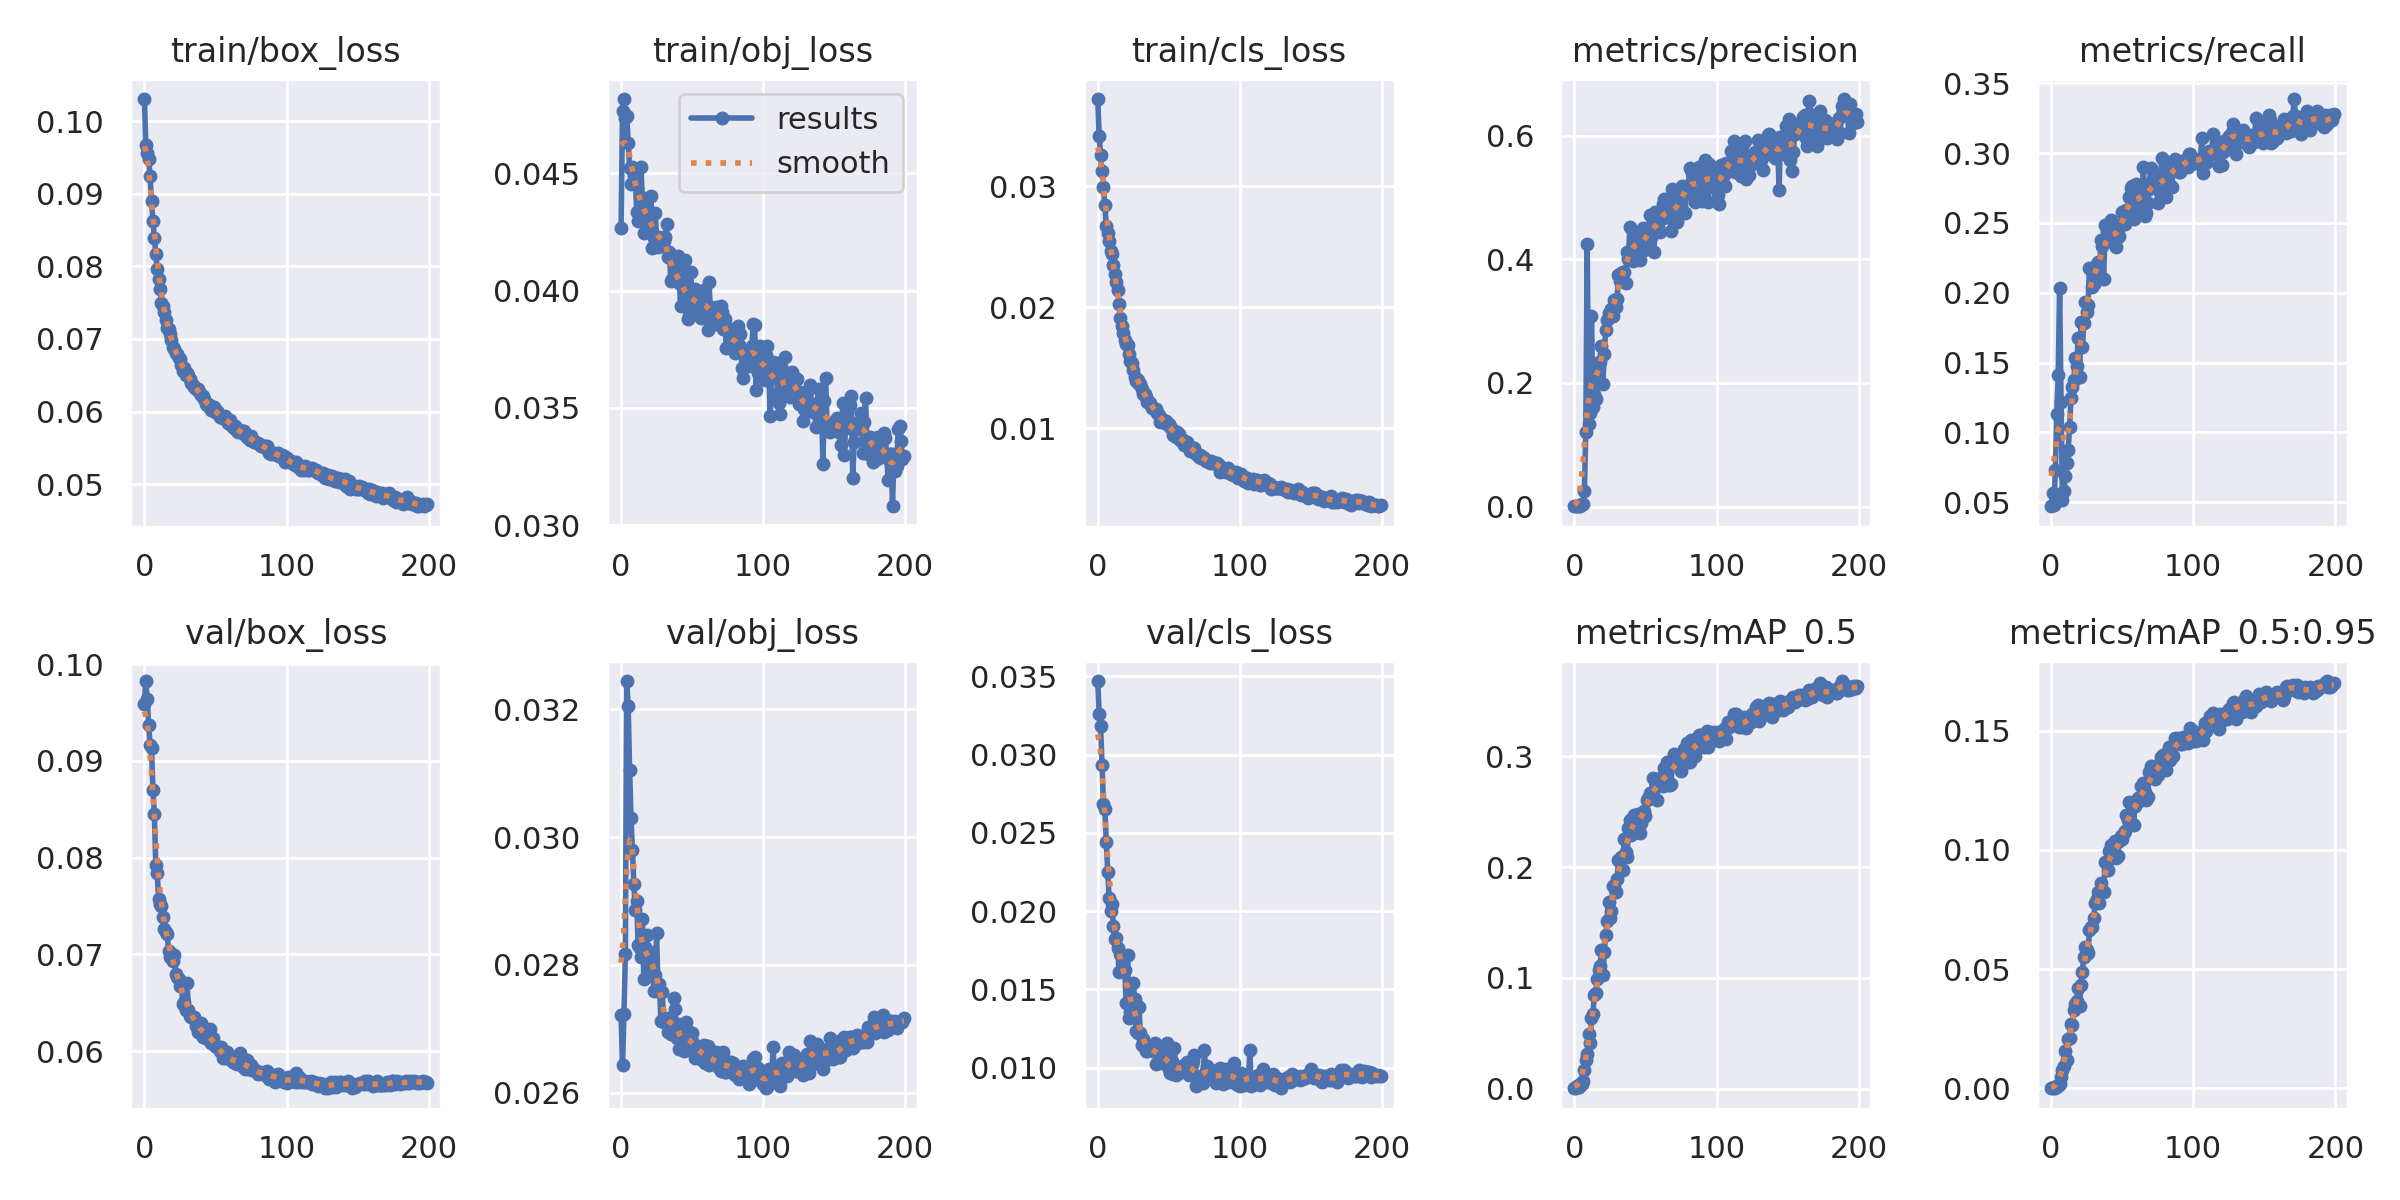

In [28]:
display(Image(filename))

### **Performance Metrics Summary**

1. **train/box_loss**: Indicates model improvement in predicting bounding boxes as training progresses, shown by decreasing loss.
2. **train/obj_loss**: Shows improvement in detecting objects and distinguishing them from the background, indicated by a decreasing trend.
3. **train/cls_loss**: Reflects better performance in classifying detected objects, indicated by decreasing loss.
4. **metrics/precision**: Increasing precision shows a reduction in false positives, indicating improved model performance.
5. **metrics/recall**: Increasing recall indicates the model is identifying more true positives, though a recall above 70% is preferable.
6. **val/box_loss**: Decreasing validation box loss shows better generalization to new data.
7. **val/obj_loss**: A decreasing trend indicates improved object detection in new data.
8. **val/cls_loss**: Decreasing validation classification loss indicates better object classification in new data.
9. **metrics/mAP_0.5**: Increasing mAP_0.5 indicates better precision-recall trade-off at an IoU threshold of 0.5.
10. **metrics/mAP_0.5:0.95**: Increasing mAP_0.5:0.95 indicates good model performance across various IoU thresholds.

#### **Conclusion and Suggestions for Improvement**

**Conclusion**: The model is performing well, with consistent improvements in both training and validation phases. Decreasing losses and increasing metrics for precision, recall, and mAP indicate effective learning and generalization capabilities.

**Suggestions for Improvement**:
- Increasing the number of training epochs from 50 to 200 would further improve model performance.
- Increase depth and width of network
- Add more layers
- More complex data augmentation methods


## Evaluate

In [29]:
wts = project + "/exp4/weights/best.pt"
wts

'runs/train/sknav2/exp4/weights/best.pt'

In [30]:
!python val.py --data "coco_person_car_bicycle.yaml" --weights {wts}

val: data=coco_person_car_bicycle.yaml, weights=['runs/train/sknav2/exp4/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-327-g098ce03f Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5n_mod summary: 202 layers, 9069352 parameters, 0 gradients, 20.2 GFLOPs
val: Scanning /content/data/filtered/labels/val2017.cache... 1031 images, 0 backgrounds, 0 corrupt: 100% 1031/1031 [00:00<?, ?it/s]
val: WARNING ⚠️ /content/data/filtered/images/val2017/000000010363.jpg: 2 duplicate labels removed
val: WARNING ⚠️ /content/data/filtered/images/val2017/000000011197.jpg: 8 duplicate labels removed
val: WARNING ⚠️ /content/data/filtered/images/val2017/000000017207.jpg: 3 duplicate labels removed
val: WAR

In [31]:
# Define the folder to zip and the output zip file name
folder_to_zip = 'runs/val/exp3'  # Replace with your folder name
output_filename = '/Users/taishajoseph/Documents/Projects/computer-vision-project/yolov5n/val/val5.zip'  # Replace with your desired zip file name

# Call the function to zip and download the folder
zip_and_download_folder(folder_to_zip, output_filename)

Folder runs/val/exp3 zipped successfully as /Users/taishajoseph/Documents/Projects/computer-vision-project/yolov5n/val/val5.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File /Users/taishajoseph/Documents/Projects/computer-vision-project/yolov5n/val/val5.zip downloaded successfully


### Visualize Results

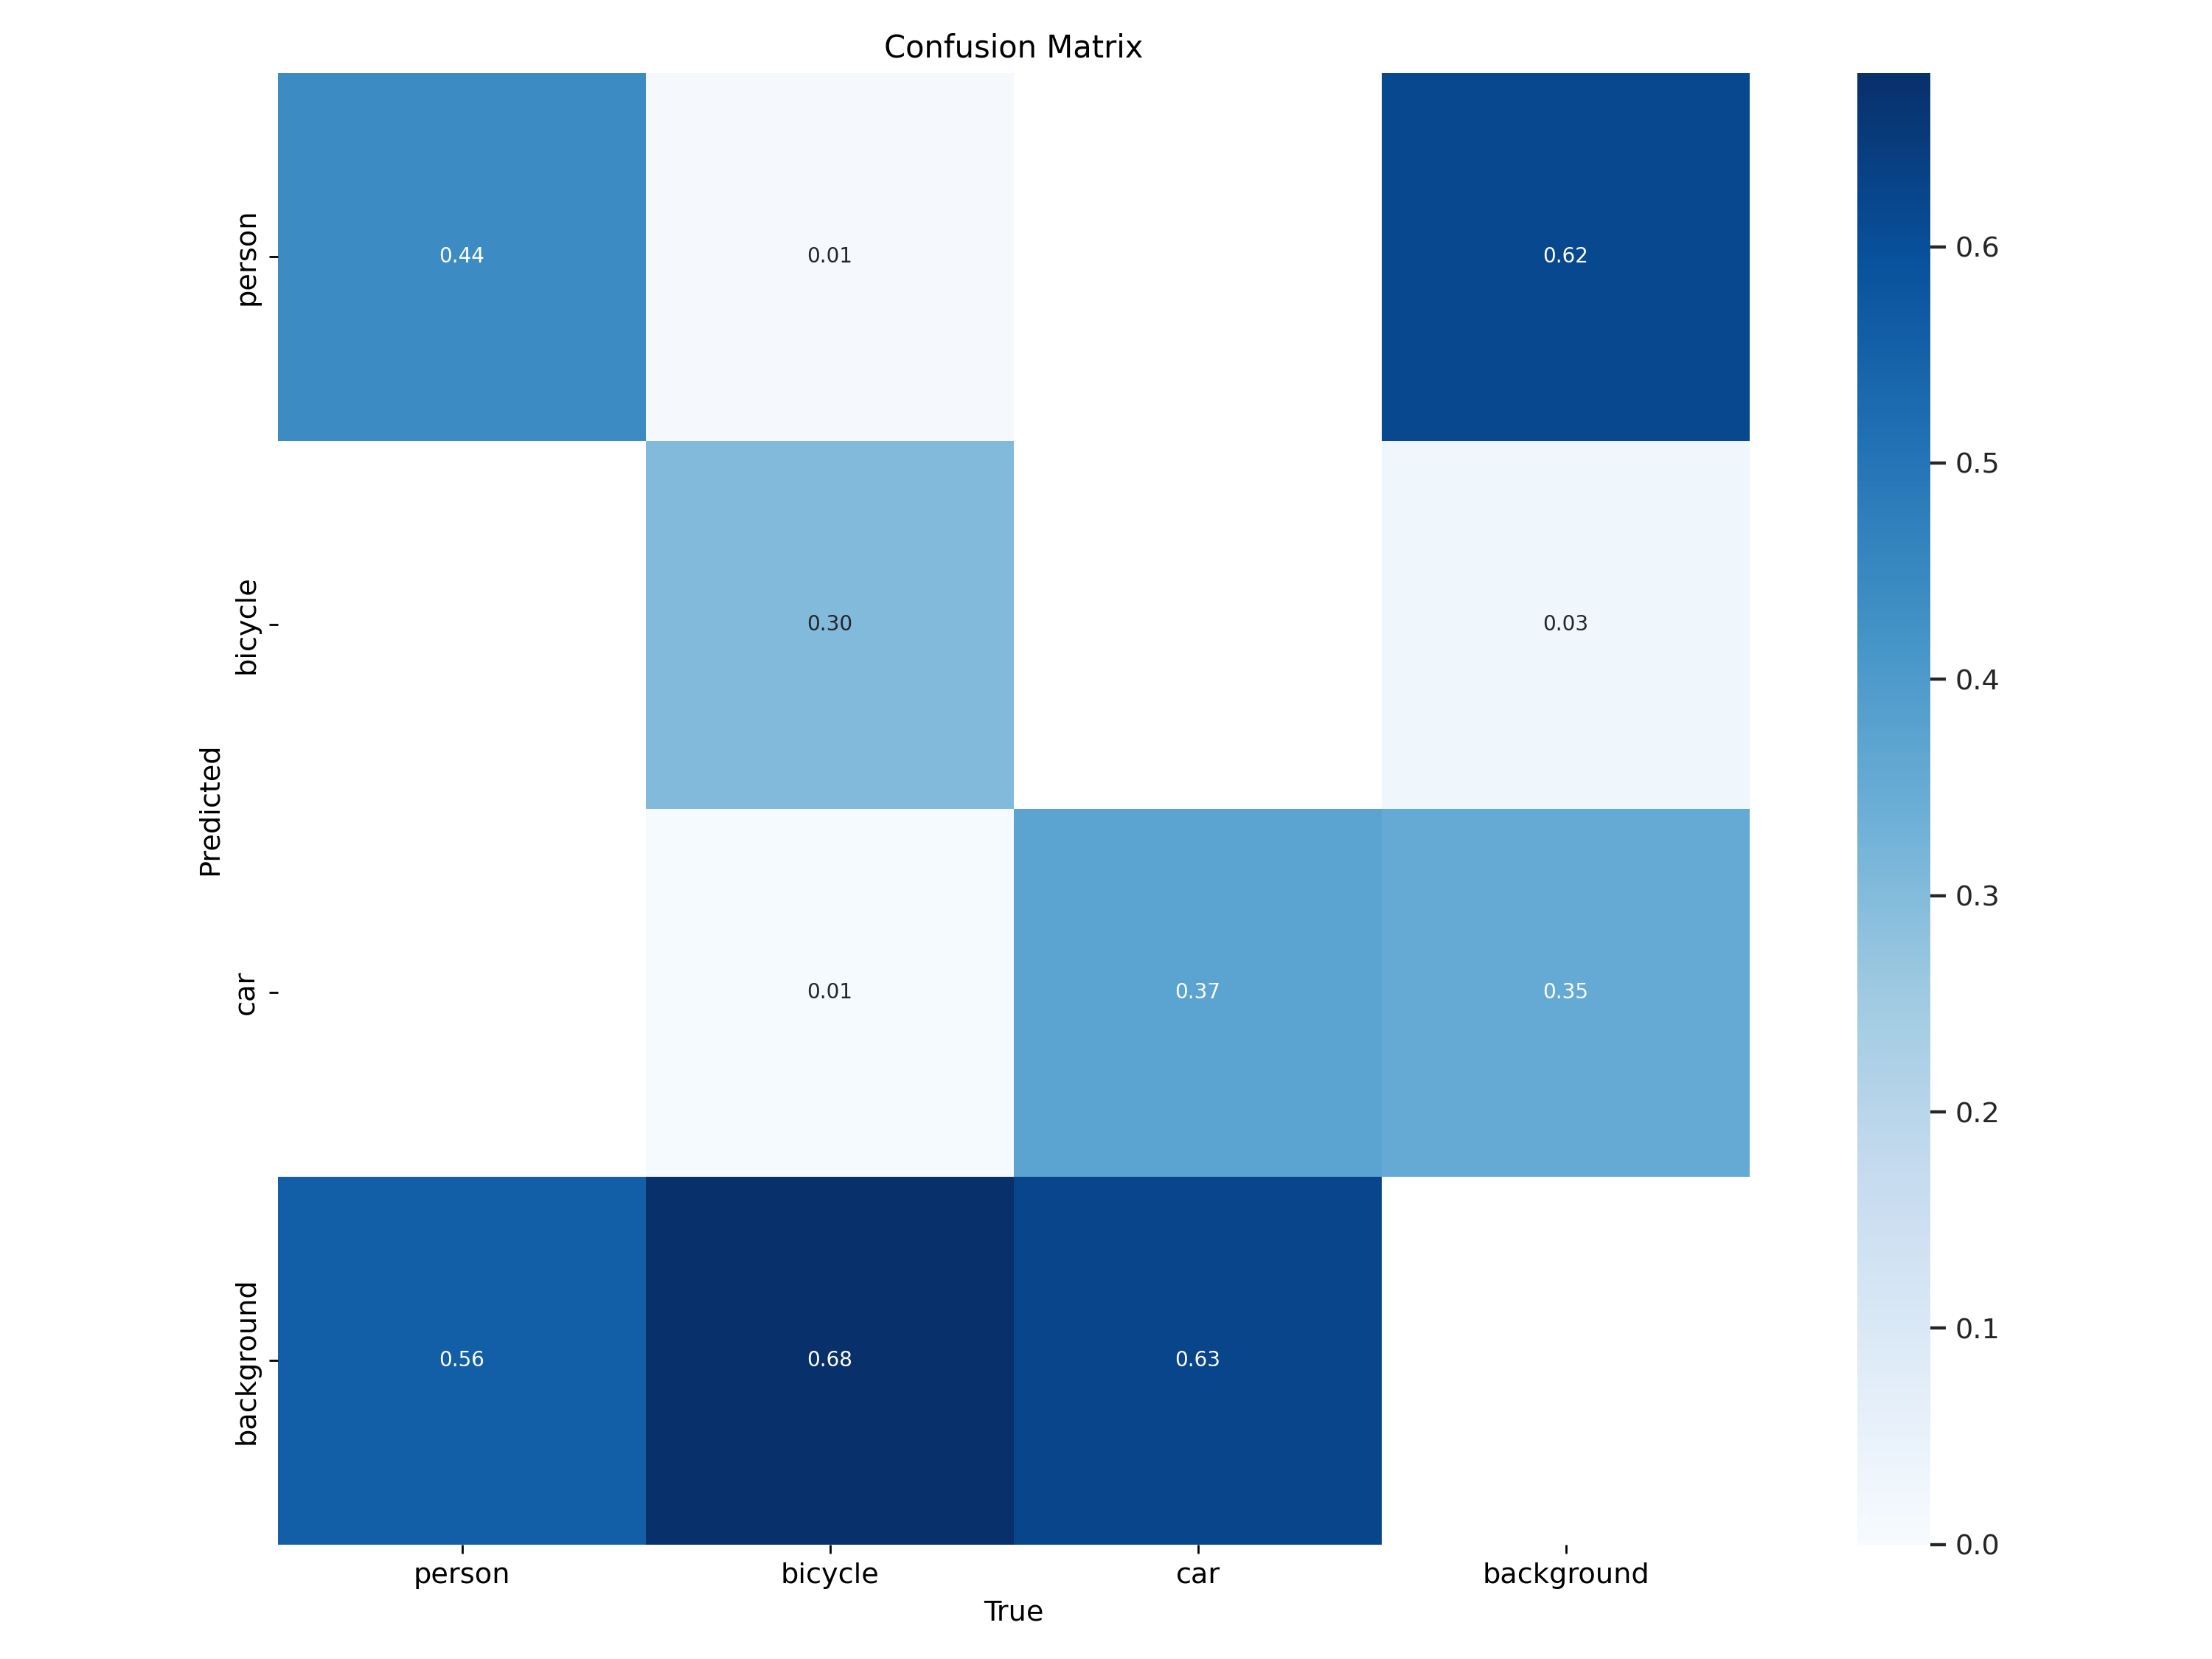

In [32]:
# import matplotlib.pyplot as plt
# from IPython.display import Image, display

# Open the image file
display(Image(filename="runs/val/exp3/confusion_matrix.png"))

# Run 1:

**Summary of Initial Model Performance on Validation data:**
- Person detection: correctly identifies person 30% of the time and misclassifies a person 69% of the time
- Car detection: correctly identifies car 26% of the time and misclassifies a car 74% of the time
- Bicycle detection:correctly identifies car 32% of the time and misclassifies a car 68% of the time

**How to Improve Classification?**
- The performance for "person," "car," and "bicycle" needs improvement. The high rates of misclassification, especially with the background, indicate that the model may benefit from additional training data, better feature extraction, or tuning of hyperparameters.
- If the dataset is imbalanced, techniques such as resampling, data augmentation, or using class weights can be utilized address the imbalance.

# Run 2:

**Summary of Model Performance on Validation data:**
- Person detection: correctly identifies person 59% of the time.
- Car detection: correctly identifies car 49% of the time.
- Bicycle detection:correctly identifies car 54% of the time.

## Inference

In [33]:
!python detect.py --weights {wts} --img 640 --conf 0.25 --source data/images

detect: weights=['runs/train/sknav2/exp4/weights/best.pt'], source=data/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-327-g098ce03f Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5n_mod summary: 202 layers, 9069352 parameters, 0 gradients, 20.2 GFLOPs
image 1/2 /content/yolov5/data/images/bus.jpg: 640x480 2 persons, 49.9ms
image 2/2 /content/yolov5/data/images/zidane.jpg: 384x640 2 persons, 50.9ms
Speed: 0.5ms pre-process, 50.4ms inference, 249.0ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp3


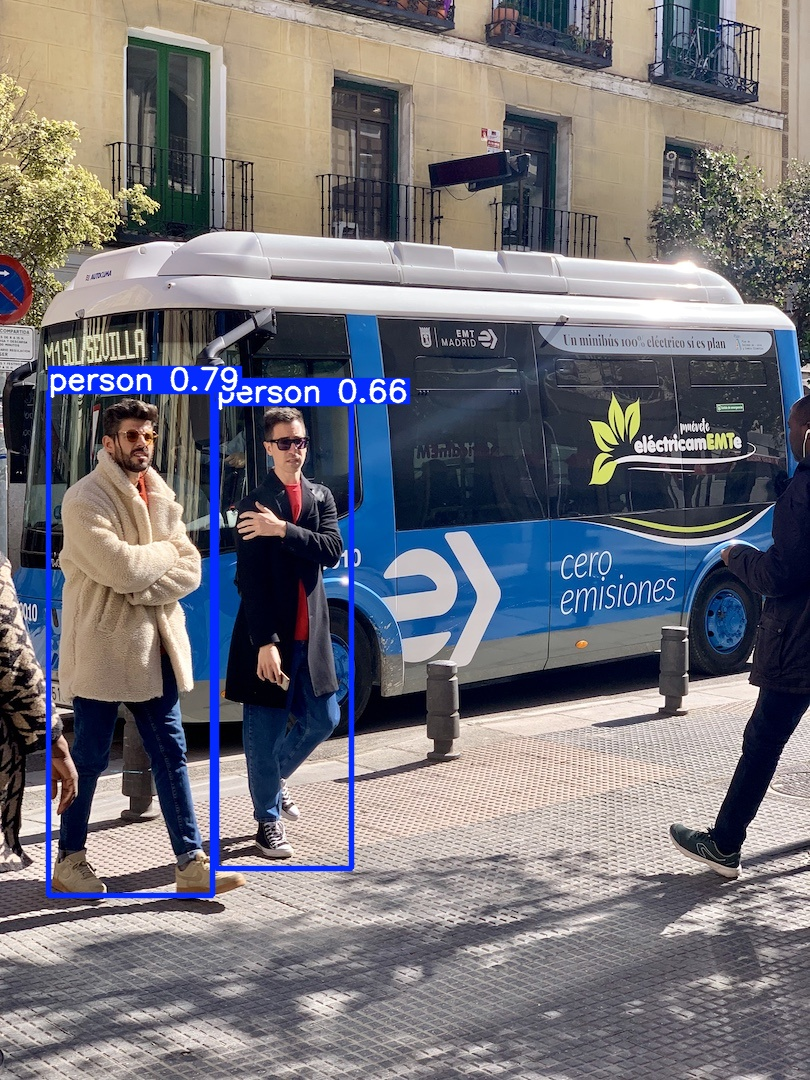

In [34]:
display(Image(filename='runs/detect/exp3/bus.jpg', width=600))

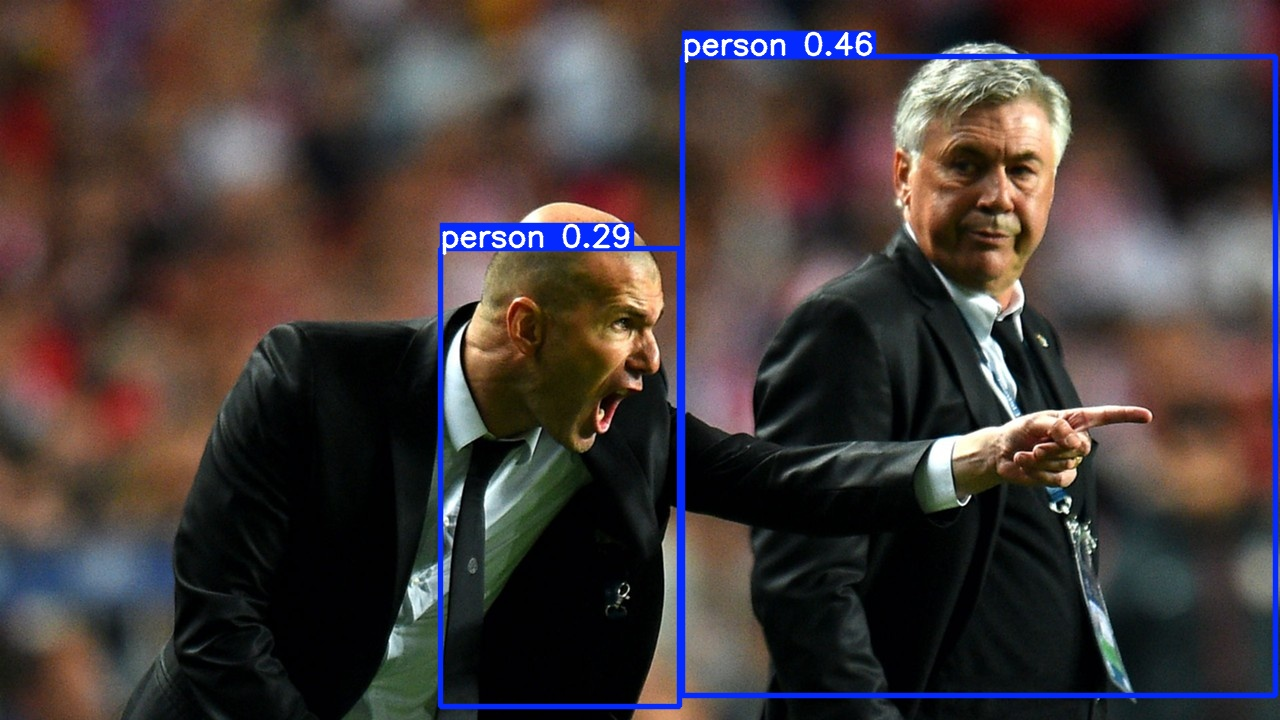

In [35]:
display(Image(filename='runs/detect/exp3/zidane.jpg', width=600))

In [36]:
# Define the folder to zip and the output zip file name
folder_to_zip = 'runs/detect/exp3'  # Replace with your folder name
output_filename = 'detect4.zip'  # Replace with your desired zip file name

# Call the function to zip and download the folder
zip_and_download_folder(folder_to_zip, output_filename)

Folder runs/detect/exp3 zipped successfully as detect4.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File detect4.zip downloaded successfully


## Clean Up

Terminate the kernel and free memory:

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)

#### References
- Jocher, G. (2020). YOLOv5 by Ultralytics (Version 7.0) [Computer software]. https://doi.org/10.5281/zenodo.3908559
- https://medium.com/@henriquevedoveli/metrics-matter-a-deep-dive-into-object-detection-evaluation-ef01385ec62
- https://vignesh943628.medium.com/metrics-on-object-detection-b9fe3f1bac59
- https://towardsdatascience.com/map-mean-average-precision-might-confuse-you-5956f1bfa9e2